## Pymoosh and Nevergrad for the inverse design of multilayered structures

This colab is based on Pymoosh (https://github.com/AnMoreau/PyMoosh) and Nevergrad (https://github.com/facebookresearch/nevergrad). If you like our codes, please consider putting a star on our githubs :-)

Context = shape optimization for photonics


# Here we do installations, imports and parametrizations. You might want to create your own copy of this colab (File, Save a copy). Edit here for parametrizing your run, before clicking on "run everything" in the "run" menu.

In [46]:
# !pip install pymoosh
# !pip install nevergrad==1.0.0

# Let us get rid of some deprecation warning in SkLearn.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")




In [68]:
# Helper function.
def doint(s):  # Converting a string into an int.
   return 7 + sum([ord(c)*i for i, c in enumerate(s)])

def get_color(o):  # Converting a string into a color.
  colors = ['b', 'g', 'r', 'c', 'y', 'k']
  algs = ["CMA", "QODE", "BFGS", "QNDE", "DE"]
  if o in algs:
      return colors[algs.index(o)]
  return colors[doint(o) % len(colors)]


# Please modify the parameters below at your best convenience.
maximum_time_per_run_in_seconds = 6000  # Maximum number of seconds per run (then: interruption).
num_experiments = 15  # Number of times we reproduce each experiments.
maximum_optimization_overhead = 50  # Maximum ratio between the computational cost and the computational cost of the objective function only.

Init = -7.0
Grad = True
Full = False
Para = False
NoverD = 10
Factor = 0


# List of optimization methods in the extended setup.
# list_optims = ["ChainMetaModelSQP", "MetaModel", "SQP", "CMA", "DE", "RotatedTwoPointsDE", "OnePlusOne", "QODE", "QNDE", "TwoPointsDE", "PSO", "GeneticDE", "NelderMead", "Cobyla" ,"Powell"]
list_optims = ["CMA", "QODE", "BFGS", "QNDE", "DE"]
#list_optims = ["NGOpt", "NGOptRW", "DE", "QODE", "QNDE", "BFGS", "GradBFGS", "CMA"]
# if you want more, you might add:  list_optims += ["BayesOptimBO", "PCABO", "RCobyla", "Shiwa", "CMandAS2", "NGOpt", "NGOptRW"]


# Choice of objective function. List of possibilities readable just below.
obj_name = "photovoltaics"
assert obj_name in ["bragg", "photovoltaics", "bigbragg", "bigphotovoltaics", "ellipsometry", "minibragg", "hugephotovoltaics"]
run_performance = True  # Whether we want to run the comparison between various optimization methods.

if obj_name == "bragg":
  nb_layers = 20
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "bigbragg":
  nb_layers = 40
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "ellipsometry":
  nb_layers = 1
  min_th = 50
  max_th = 150

elif obj_name == "photovoltaics":
  nb_layers = 10
  min_th = 30
  max_th = 250

elif obj_name == "bigphotovoltaics":
  nb_layers = 20
  min_th = 30
  max_th = 250

elif obj_name == "minibragg":
  nb_layers = 10
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "hugephotovoltaics":
  nb_layers = 32
  min_th = 30
  max_th = 250

else:
  assert False, f"Unknown objective function {obj_name}"

dim = 2 * nb_layers if "ellipsometry" in obj_name else nb_layers

budget = dim * 1000
if obj_name == "ellipsometry":
  budget = 1000

# if dim < 15 and budget < 1200:  # We remove Bayesian optimization from high-dimensional contexts.
#   list_optims += ["BO"]  #, "PCABO"]

# All problems.
min_ind = 1.1
max_ind = 3

context_string = f"We work on {obj_name}, dim={dim}, budget={budget}, bounds=[{min_th},{max_th}]"
print(context_string)

We work on photovoltaics, dim=10, budget=10000, bounds=[30,250]



# Here we define the Pymoosh objective functions.

In [49]:
import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np

def bragg(x):
  # This cost function corresponds to the problem
  # of maximizing the reflectance, at a given wavelength,
  # of a multilayered structure with alternating refractive
  # indexes. This problem is inspired by the first cases studied in
  # https://www.nature.com/articles/s41598-020-68719-3
  # :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:
  # The input, x, corresponds to the thicknesses of all the layers, :
  # starting with the upper one.                                    :
  # :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:
  x = list(x)
  n = len(x)
  # Working wavelength
  wl = 600.
  materials = [1,1.4**2,1.8**2]
  stack = [0] + [2,1] * (n//2) + [2]
  thicknesses = [0.] + list(x) + [0.]
  structure = pm.Structure(materials,stack,np.array(thicknesses),verbose = False)
  _, R = pm.coefficient_I(structure,wl,0.,0)
  cost = 1-R
  return cost

def photovoltaics(x):
  n = len(x)
  materials = [1., 2., 3., "SiA"]
  stack = [0] + [1,2] * (n//2) + [3]
  thicknesses = [0] + list(x) + [30000]
  structure = pm.Structure(materials, stack, np.array(thicknesses), verbose = False)
  incidence = 0
  pola = 0
  wl_min = 375
  wl_max = 750
  active_lay = len(thicknesses) - 1
  number_pts = 300
  eff, curr, curr_max, wl, spectrum, absorb4 = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
  cost = 1 - eff
  return cost

mat = [1.] + [np.random.random()*(max_ind-min_ind) + min_ind for _ in range(nb_layers)] + ["Gold"]
layers = list(range(nb_layers+2))
structure = [0] + [np.random.random()*(max_th-min_th) + min_th for _ in range(nb_layers)] + [0]


angle = 40*np.pi/180
wav_list = np.linspace(400, 800, 100)



def ref_structure(mat, layers, structure, wav_list, angle):
    struct = pm.Structure(mat, layers, structure,verbose = False)
    ellips = np.zeros(len(wav_list), dtype=complex)
    for i, wav in enumerate(wav_list):
        r_s, _, _, _ = pm.coefficient(struct, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(struct, wav, angle, 1)

        ellips[i] = r_p/r_s
    return ellips, struct

ref_ellips, ellips_structure = ref_structure(mat, layers, structure, wav_list, angle)

def ellipsometry(X, ref_ellips=ref_ellips, wav_list=wav_list, angle=angle, nb_layers=nb_layers):
    mat = [1.] + [x for x in X[:nb_layers]] + ["Gold"]
    layers = [i for i in range(nb_layers+2)]
    structure = np.array([0] + [x for x in X[nb_layers:]] + [0])

    ellips = np.zeros(len(wav_list), dtype=complex)
    interface = pm.Structure(mat, layers, structure, verbose=False)
    for i, wav in enumerate(wav_list):
        r_s, _, _, _ = pm.coefficient_A(interface, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient_A(interface, wav, angle, 1)

        ellips[i] = r_p/r_s

    return np.sum(np.abs(ellips - ref_ellips))


objective_function = {"bragg": bragg, "minibragg": bragg, "bigbragg": bragg, "photovoltaics": photovoltaics, "bigphotovoltaics": photovoltaics, "ellipsometry": ellipsometry}[obj_name]




# Simple running example for DE with Bragg

In [61]:
if "bragg" in obj_name:

  # X_min = np.array([min_th]*nb_layers)
  # X_max = np.array([max_th]*nb_layers)


  # best, convergence = pm.differential_evolution(bragg, budget, X_min, X_max)

  # plt.plot(convergence)
  # plt.xlabel("Optimization step")
  # plt.ylabel("Cost")
  # plt.show()
  nb_layers = 10
  def bragg_plot(best):
    plt.figure(figsize=(5, 4))
    # Showing the final spectrum
    materials = [1,mat1**2,mat2**2]
    stack = [0] + [2,1] * (len(best) //2) + [2]
    thicknesses = [0.] + [t for t in best] + [0.]

    bragg_mirror = [opti_wave / (4*np.sqrt(materials[2])), opti_wave / (4*np.sqrt(materials[1]))] * (nb_layers//2)
    bragg_th = [0.] + [t for t in bragg_mirror] + [0.]
    structure = pm.Structure(materials,stack,thicknesses,verbose = False)
    bragg_structure = pm.Structure(materials,stack,bragg_th,verbose = False)

    wavelengths = np.linspace(opti_wave-150, opti_wave+150, 300)
    spectrum = np.zeros_like(wavelengths)
    bragg_spectrum = np.zeros_like(wavelengths)
    for i, wav in enumerate(wavelengths):
      _,_,R,_ = pm.coefficient(structure,wav,0.,0)
      spectrum[i] = R
      _,_,R,_ = pm.coefficient(bragg_structure,wav,0.,0)
      bragg_spectrum[i] = R

  # plt.plot(wavelengths, spectrum, label="Optimized structure")
    plt.plot(wavelengths, bragg_spectrum, label="Bragg mirror")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Reflectivity")
    plt.legend()
    plt.show()

    plt.figure(figsize=(4, 4))
    # structure.plot_stack(wavelength=opti_wave, )
    bragg_structure.plot_stack(wavelength=opti_wave)

  # bragg_plot(best)


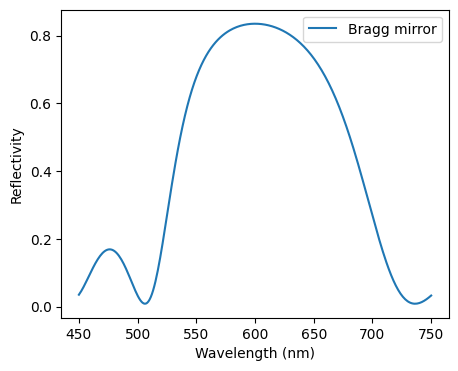

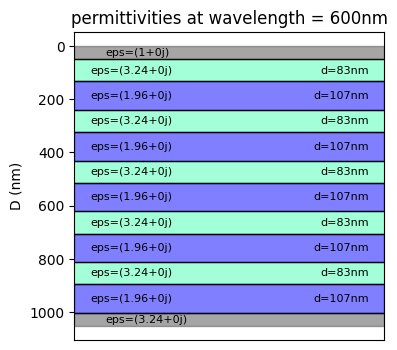

In [62]:
mini_solution = [
    83.3255571740911, 107.1472001600552, 83.32277947536926, 107.1479545968577,
    83.34420975184776, 107.1241862628867, 83.34176626802375, 107.12843686939664,
    83.33598175416009, 107.14582501973545
]

solution = [83.35015377473458, 107.15866789536955, 83.32316492018815,
            107.13719586980783, 83.35566467743038, 107.11529061832779,
            83.33552166871466, 107.13021864727196, 83.33834344816559,
            107.13598204525299, 83.3684027792954, 107.10294216455648,
            83.32910852896832, 107.11566283334697, 83.36955735245317,
            107.11863291206834, 83.33458286124984, 107.12142439597889,
            83.35217959482218, 107.1451646164283]
best = np.array(mini_solution)
bragg_plot(best)

# Simple running example for DE with Photovoltaics





In [78]:
if "photovoltaics" in obj_name:

  # X_min = np.array([min_th]*nb_layers)
  # X_max = np.array([max_th]*nb_layers)

  # best, convergence = pm.differential_evolution(photovoltaics, budget, X_min, X_max)

  # plt.figure(2)
  # plt.plot(convergence)
  # plt.xlabel("Optimization step")
  # plt.ylabel("Cost")
  # plt.show()

  def photovoltaics_plot(b):
      # plt.figure(figsize=(4, 4))
      # Showing the final spectrum
      materials = [1., 2., 3., "SiA"]
      stack = [0] + [1,2] * (len(b) // 2) + [3]
      thicknesses = [0.] + [t for t in b] + [30000.]

      structure = pm.Structure(materials, stack, thicknesses, verbose = False)
      incidence = 0
      pola = 0
      wl_min = 375
      wl_max = 750
      active_lay = len(thicknesses) - 1
      number_pts = 300
      eff, curr, curr_max, wl, spectrum, absorb_opt = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)

      # plt.plot(wl, absorb_opt, label = "optimized absorption")
      # plt.xlabel("Wavelength (nm)")
      # plt.ylabel("Absorption")
      # plt.legend()
      # plt.show()

      # plt.figure(figsize=(3, 5))
      # thicknesses_for_image = [30] + [t for t in b] + [30]
      # structure_image = pm.Structure(materials, stack, thicknesses_for_image, verbose = False)
      # structure_image.plot_stack()
      return wl, absorb_opt

  # photovoltaics_plot(best)


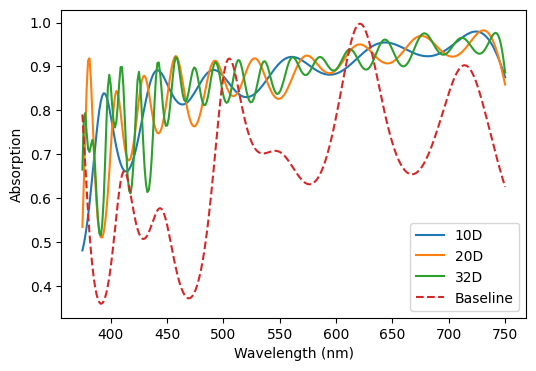

In [80]:
x_10D = [82.91878953411792, 94.94796065348898, 161.30252260621486,
         117.93251120736815, 151.04407112019794, 122.76895306993433,
         138.34648553731563, 131.1433529166783, 94.15580272014004,
         71.88084238370156]
x_20D = [84.50290875364578, 113.32466386141617, 179.53502420261105,
         154.51067583734246, 190.77045193635325, 152.05376222876438,
         32.67570025570236, 30, 33.159644061465215, 142.6007861435155,
         170.5899792178347, 30, 30, 30, 164.12846590768424, 125.8979120263261,
         140.20022680620207, 131.45490726698753, 94.03483450132948,
         72.32860024434018]
x_32D = [84.69997606899662, 104.06732284542417, 167.41093032200442,
         140.3059021853086, 187.18030222282843, 174.17321402935053,
         46.39227436851347, 32.16152433357266, 51.720463728383066,
         163.66481695899466, 204.06538344080062, 37.07547951986518,
         51.73414554770518, 38.867212930891455, 47.721326394629166,
         164.55749383919743, 190.61290245490525, 159.29235249869345,
         193.10615824711203, 173.96118122857544, 31.523093532952185,
         167.39966073994918, 176.39741295561794, 175.65268066039852,
         40.00998052509715, 38.0113341866573, 203.96803396663583,
         132.32102225314264, 143.19660205678264, 132.1892006869166,
         94.78512285777896, 71.80404587442159]

x_rand = [np.random.uniform(min_th, max_th) for _ in range(nb_layers)]

plt.figure(figsize=(6, 4))
wls = []
absorbs = []
for x in [x_10D, x_20D, x_32D, x_rand]:
  wl, absorb = photovoltaics_plot(np.array(x))
  wls.append(wl)
  absorbs.append(absorb)
plt.plot(wls[0], absorbs[0], label="10D")
plt.plot(wls[1], absorbs[1], label="20D")
plt.plot(wls[2], absorbs[2], label="32D")
plt.plot(wls[3], absorbs[3], linestyle="--" , label="Baseline")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption")
plt.legend()
plt.show()



# Simple running example for DE with Ellipsometry

In [ ]:


if "ellipsometry" in obj_name:  # See parametrization at the top of the present colab.
  nb_runs = 2

  X_min = np.array([min_ind] * (nb_layers) +  [min_th] * (nb_layers))
  X_max = np.array([max_ind] * (nb_layers) +  [max_th] * (nb_layers))

  convs = []
  bests = []
  scores = []
  for i in range(nb_runs):
    print(f"{i+1} / {nb_runs}")
    best, convergence = pm.differential_evolution(ellipsometry, budget, X_min, X_max)
    bests.append(best)
    convs.append(convergence)
    scores.append(convergence[-1])

  order = np.argsort(scores)
  print(order)

  # Last structure
  mat = [1.] + [x for x in best[:nb_layers]] + ["Gold"]
  layers = [i for i in range(nb_layers+2)]
  structure = [0] + [x for x in best[nb_layers:]] + [0]
  best_struct = pm.Structure(mat, layers, structure)

  for i in range(nb_runs):
    plt.plot(convs[i])
  plt.xlabel("Optimization step")
  plt.ylabel("Cost")
  plt.show()

  # Best ever structure
  best = bests[order[0]]
  mat = [1.] + [x for x in best[:nb_layers]] + ["Gold"]
  layers = [i for i in range(nb_layers+2)]
  structure = [0] + [x for x in best[nb_layers:]] + [0]
  best_struct = pm.Structure(mat, layers, structure)


  ellips_structure.plot_stack()
  best_struct.plot_stack()

1 / 2
2 / 2
[0 1]
List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.2627967771853377
Database material: Gold, model: Brendel Bormann
List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.2675854720302873
Database material: Gold, model: Brendel Bormann


# Performance comparisons

Here we compare different optimization methods.
The list of these methods is in the top code block.
The objective function used in the comparison is specified in the top code block.
The next code block does the plottings.

In [ ]:
if run_performance:

    import time
    # Now we run all algorithms and we store results in dictionaries.
    scores = {}
    computational_cost = {}
    yval = {}
    for optim_name in list_optims:
        print("Running ", optim_name)
        scores[optim_name] = []
        computational_cost[optim_name] = []
        yval[optim_name] = []
        for xp in range(num_experiments):
            # We slightly randomize the upper bound, for checking the robustness.
            r = 0. if xp == 0 else (
                np.random.rand() - 0.5) * (max_th - min_th) * .1
            if obj_name == "ellipsometry":
                array1 = ng.p.Array(shape=(nb_layers,),
                                    lower=min_ind, upper=max_ind)
                array2 = ng.p.Array(shape=(nb_layers,),
                                    lower=min_th, upper=max_th - r)
                instrumentation = ng.p.Instrumentation(
                    array1,
                    array2,
                )
            else:
                v = min_th + (max_th - min_th - r) * Init / 6.
                if Init < 0:
                    init_array = [min_th + (max_th - min_th - r) *
                            np.random.rand() for _ in range(dim)]
                else:
                    init_array = [v] * dim
                instrumentation = ng.p.Array(init=np.array(
                    init_array), lower=min_th, upper=max_th - r)
            optim = ng.optimizers.registry[optim_name](instrumentation, budget)
            if Init < -7 and not "BFGS" in optim_name:
                for _ in range(30):
                    optim.suggest([min_th + (-min_th + max_th - r)
                                  * np.random.rand() for _ in range(dim)])
            best_y = float("inf")
            t0 = time.time()
            xval = []
            obj_time = float("inf")
            for k in range(budget):
                if time.time() - t0 < min(maximum_time_per_run_in_seconds, maximum_optimization_overhead * (k+1) * obj_time):
                    x = optim.ask()
                    t1 = time.time()
                    val = x.value
                    if obj_name == "ellipsometry":
                        val = list(val[0][0]) + list(val[0][1])
                    elif obj_name == "ellipsometry2":
                        val = [val[0][i][0] for i in range(len(val[0]))]
                    y = objective_function(val)
                    obj_time = float(time.time() - t1)
                    optim.tell(x, y)
                    if y < best_y:
                        best_y = y
                if int(np.log2(k + 1) + .999999) == int(np.log2((k + 1))) or k == budget - 1:
                    xval += [k+1]
                    if len(yval[optim_name]) < len(xval):
                        yval[optim_name] += [[]]
                    yval[optim_name][len(xval)-1] += [best_y]
            computational_cost[optim_name] += [time.time() - t0]
            scores[optim_name] += [best_y]

Running  CMA
Running  QODE
Running  BFGS
Running  QNDE
Running  DE


In [ ]:
yval

{'CMA': [[0.8804347979641753, 0.5239818485422217, 0.766072680279764, 0.6715653913615693, 0.8630627967316498, 0.9977564108269228, 0.651707321887167, 0.7813930199278036, 0.8035089523438174, 0.9857899020358327, 0.8611922861847329, 0.7402328985362443, 0.7499079413819347, 0.8503895448447061, 0.708259877451783], [0.6877698187142165, 0.5008633485210028, 0.766072680279764, 0.4270910247422124, 0.8630627967316498, 0.9834340864277655, 0.651707321887167, 0.7813930199278036, 0.6106012169517232, 0.889180116158595, 0.5887788268753764, 0.7402328985362443, 0.7499079413819347, 0.690901601211684, 0.6650582730661719], [0.6566009490516005, 0.5008633485210028, 0.7533024383378579, 0.36880715990933843, 0.7366515745702885, 0.9565929485176867, 0.651707321887167, 0.7150829773285271, 0.6106012169517232, 0.889180116158595, 0.5887788268753764, 0.7402328985362443, 0.7499079413819347, 0.690901601211684, 0.6650582730661719], [0.6566009490516005, 0.3907751575254711, 0.7077295792839027, 0.36880715990933843, 0.7366515745

In [ ]:
xval = []
for k in range(budget):
    if int(np.log2(k + 1) + .999999) == int(np.log2((k + 1))) or k == budget - 1:
        xval += [k+1]
print(len(xval))
print(xval)

15
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 10000]


In [ ]:
keys = ["alg", "xval", "yval", "run"]
values = []
for run in range(num_experiments):
    for k in yval.keys():
        for i in range(len(yval[k])):
            values += [[k, xval[i], yval[k][i][run], run]]
import pandas as pd
df = pd.DataFrame(values, columns=keys)
df.to_csv(f"exp_data/CAI/{obj_name}.csv", index=False)
print(df)
# print(np.array(values))

      alg   xval      yval  run
0     CMA      1  0.880435    0
1     CMA      2  0.687770    0
2     CMA      4  0.656601    0
3     CMA      8  0.656601    0
4     CMA     16  0.656601    0
...   ...    ...       ...  ...
1120   DE   1024  0.212631   14
1121   DE   2048  0.175837   14
1122   DE   4096  0.173906   14
1123   DE   8192  0.173906   14
1124   DE  10000  0.173906   14

[1125 rows x 4 columns]


# Below a code block for plotting the results.

CMA
CMA [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 10000] [[0.6386101157736022, 0.9490308908418806, 0.8070581912814772, 0.9725685684841392, 0.6078066639058521, 0.9348478607871666, 0.8568176080403966, 0.569242571312071, 0.585510346394591, 0.9217999299957984, 0.9067080936230703, 0.9923108106074168, 0.9769016986609795, 0.8760572197982817, 0.9291673727757274, 0.6974967073520092, 0.741618538641027, 0.9911858180569045, 0.8655006586993659, 0.768346894201621, 0.9801357958054024, 0.7899307854249833, 0.9771280472240994, 0.9544204571237499, 0.9483598909938378, 0.6827866737050974, 0.961281892836639, 0.7928079182343329, 0.9788013170103277, 0.61598852276256, 0.9784896806012185], [0.6386101157736022, 0.882493043995173, 0.8070581912814772, 0.9725685684841392, 0.5641900522251109, 0.9348478607871666, 0.8568176080403966, 0.569242571312071, 0.585510346394591, 0.7661738756543521, 0.9067080936230703, 0.9690562616967892, 0.9469238687222763, 0.7472782557860334, 0.8216823971311301, 0.69749

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

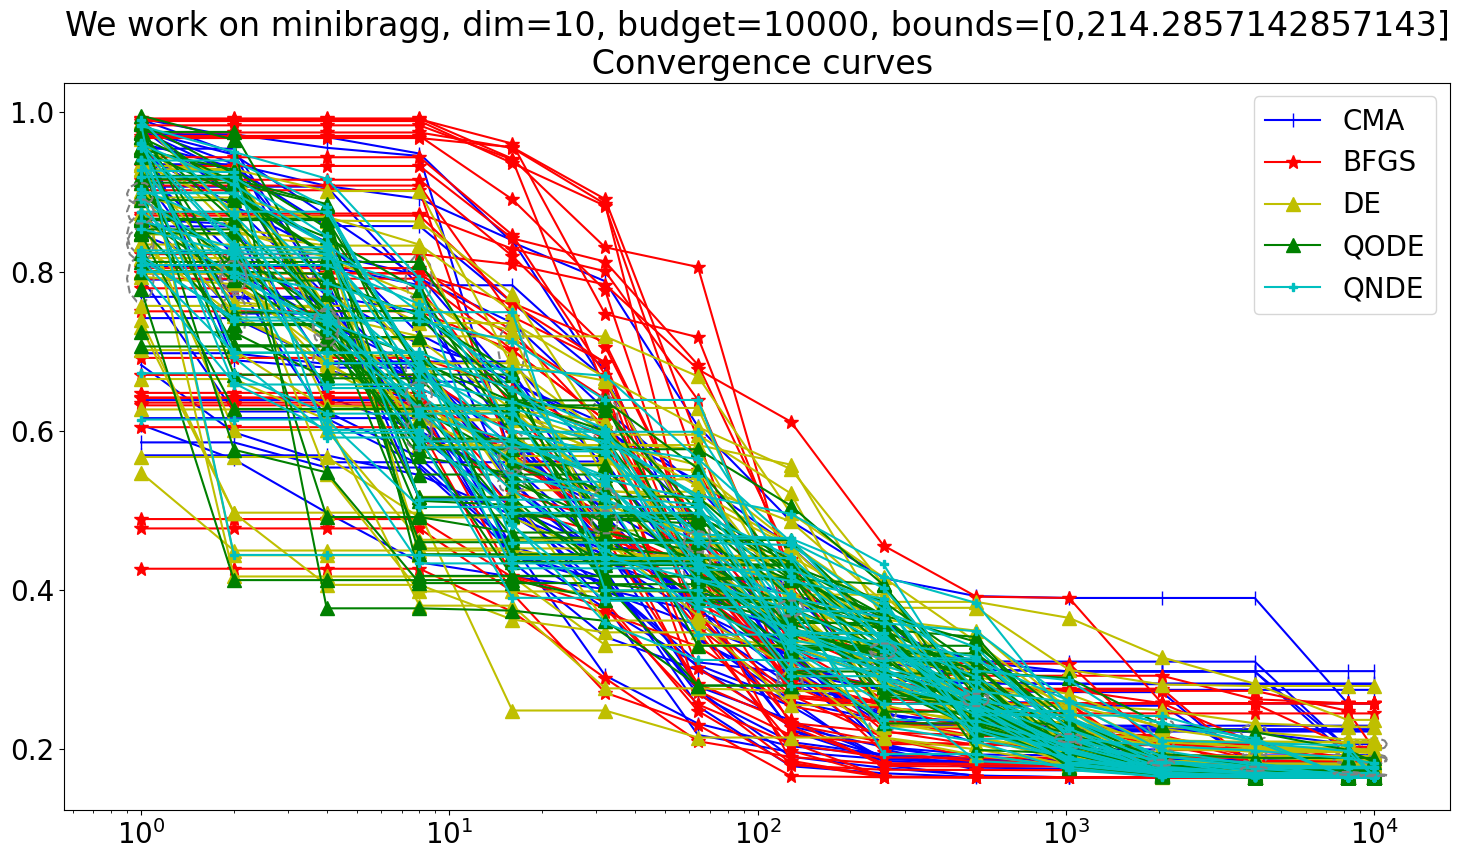

CMA [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 10000] [[0.6386101157736022, 0.9490308908418806, 0.8070581912814772, 0.9725685684841392, 0.6078066639058521, 0.9348478607871666, 0.8568176080403966, 0.569242571312071, 0.585510346394591, 0.9217999299957984, 0.9067080936230703, 0.9923108106074168, 0.9769016986609795, 0.8760572197982817, 0.9291673727757274, 0.6974967073520092, 0.741618538641027, 0.9911858180569045, 0.8655006586993659, 0.768346894201621, 0.9801357958054024, 0.7899307854249833, 0.9771280472240994, 0.9544204571237499, 0.9483598909938378, 0.6827866737050974, 0.961281892836639, 0.7928079182343329, 0.9788013170103277, 0.61598852276256, 0.9784896806012185], [0.6386101157736022, 0.882493043995173, 0.8070581912814772, 0.9725685684841392, 0.5641900522251109, 0.9348478607871666, 0.8568176080403966, 0.569242571312071, 0.585510346394591, 0.7661738756543521, 0.9067080936230703, 0.9690562616967892, 0.9469238687222763, 0.7472782557860334, 0.8216823971311301, 0.697496707

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

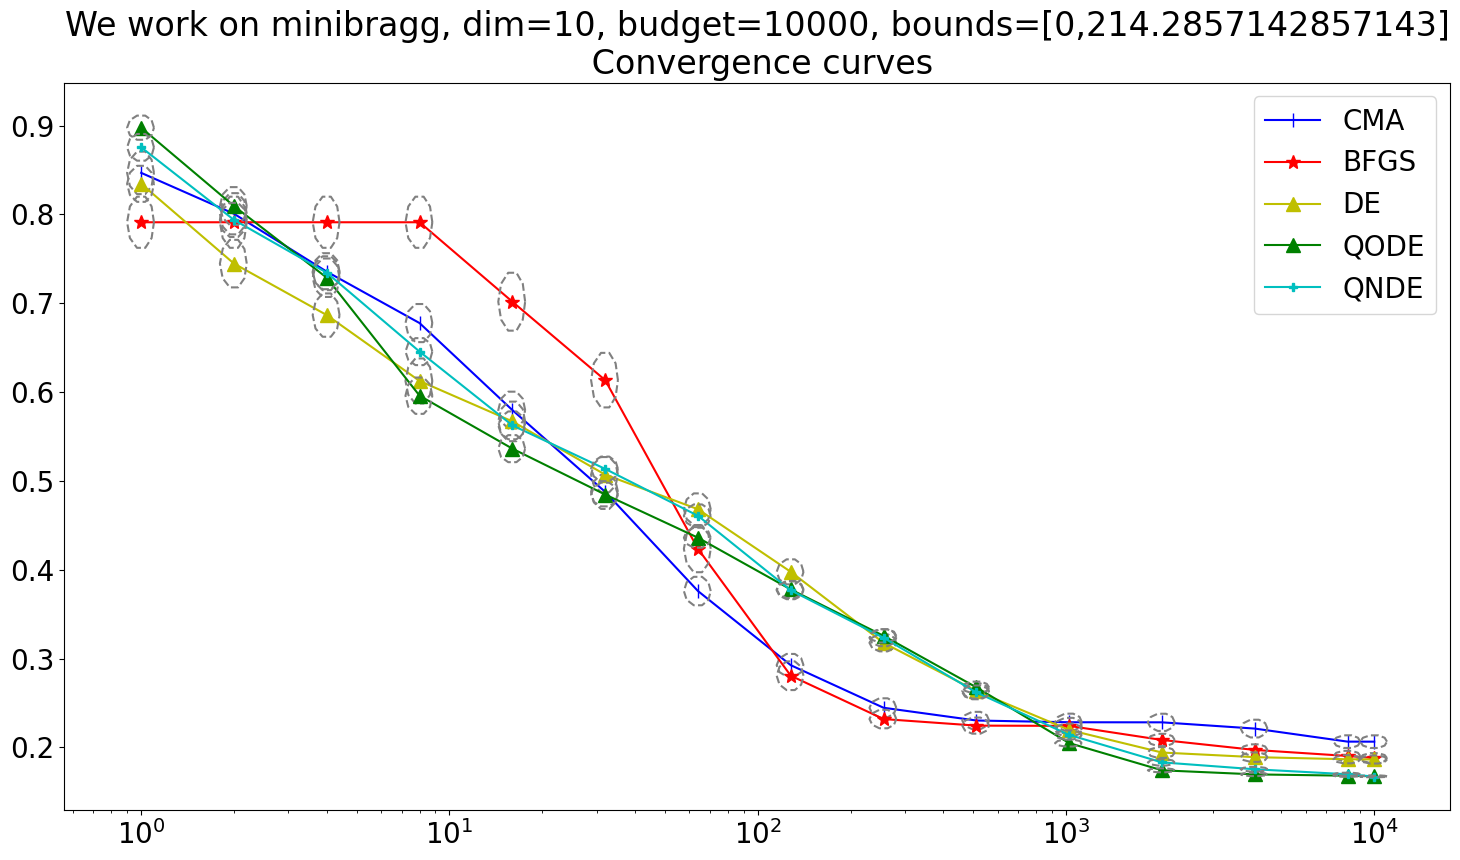

DE 0.1864257782901972 +- 0.0047123748587004355    in time  9.539340142280825
QODE 0.1675620081531918 +- 0.0009986161856575693    in time  9.590422091945525
BFGS 0.18803431128865628 +- 0.005719267249761116    in time  10.404242377127371
QNDE 0.16720575260727236 +- 0.0008414370803808545    in time  13.334397169851488
CMA 0.20649722810728557 +- 0.007343468275619802    in time  21.9212589956099


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

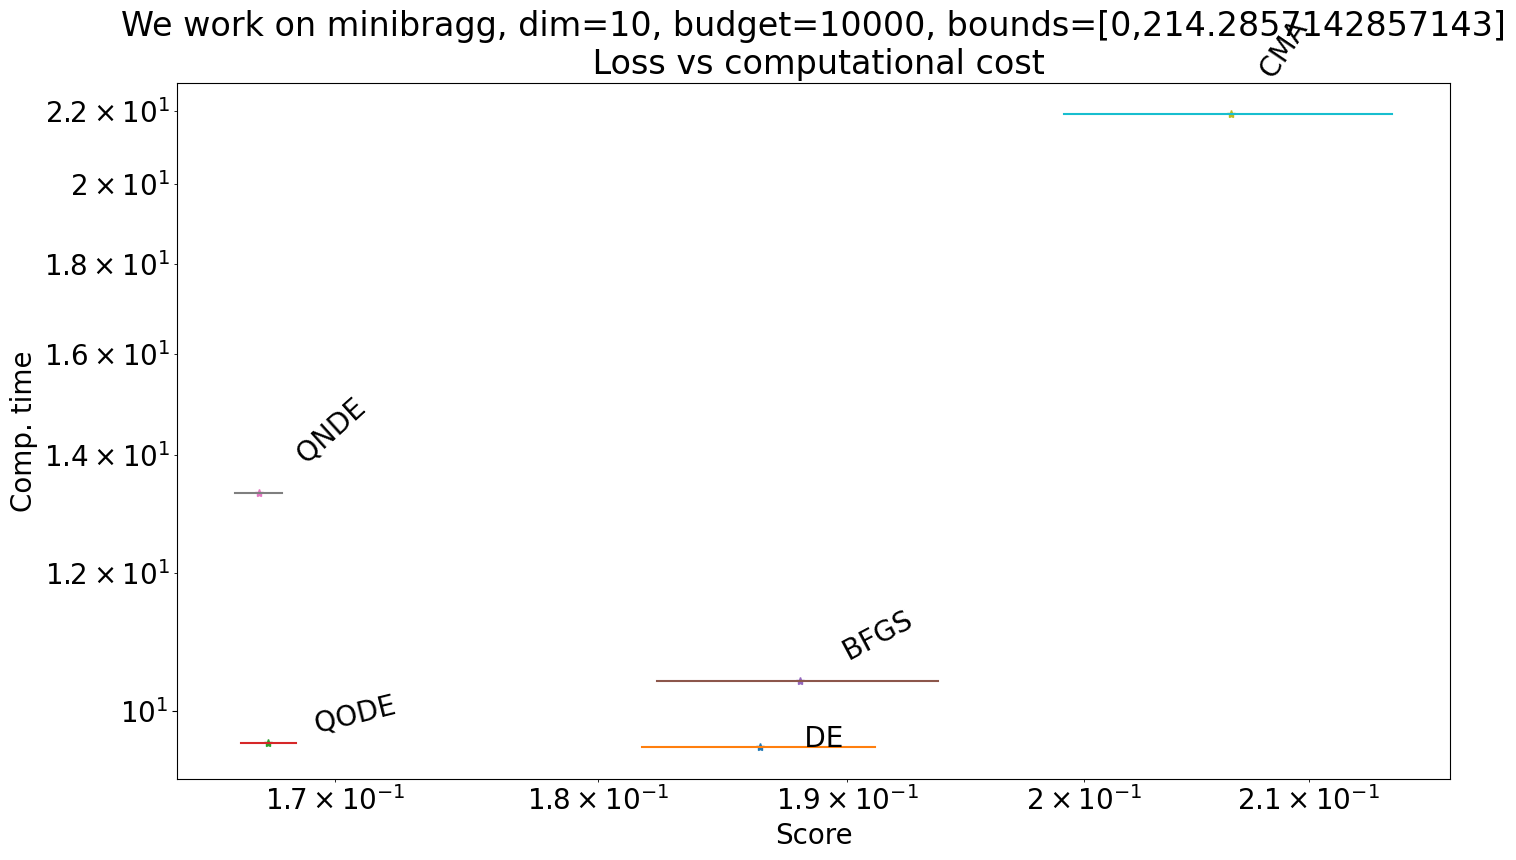

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

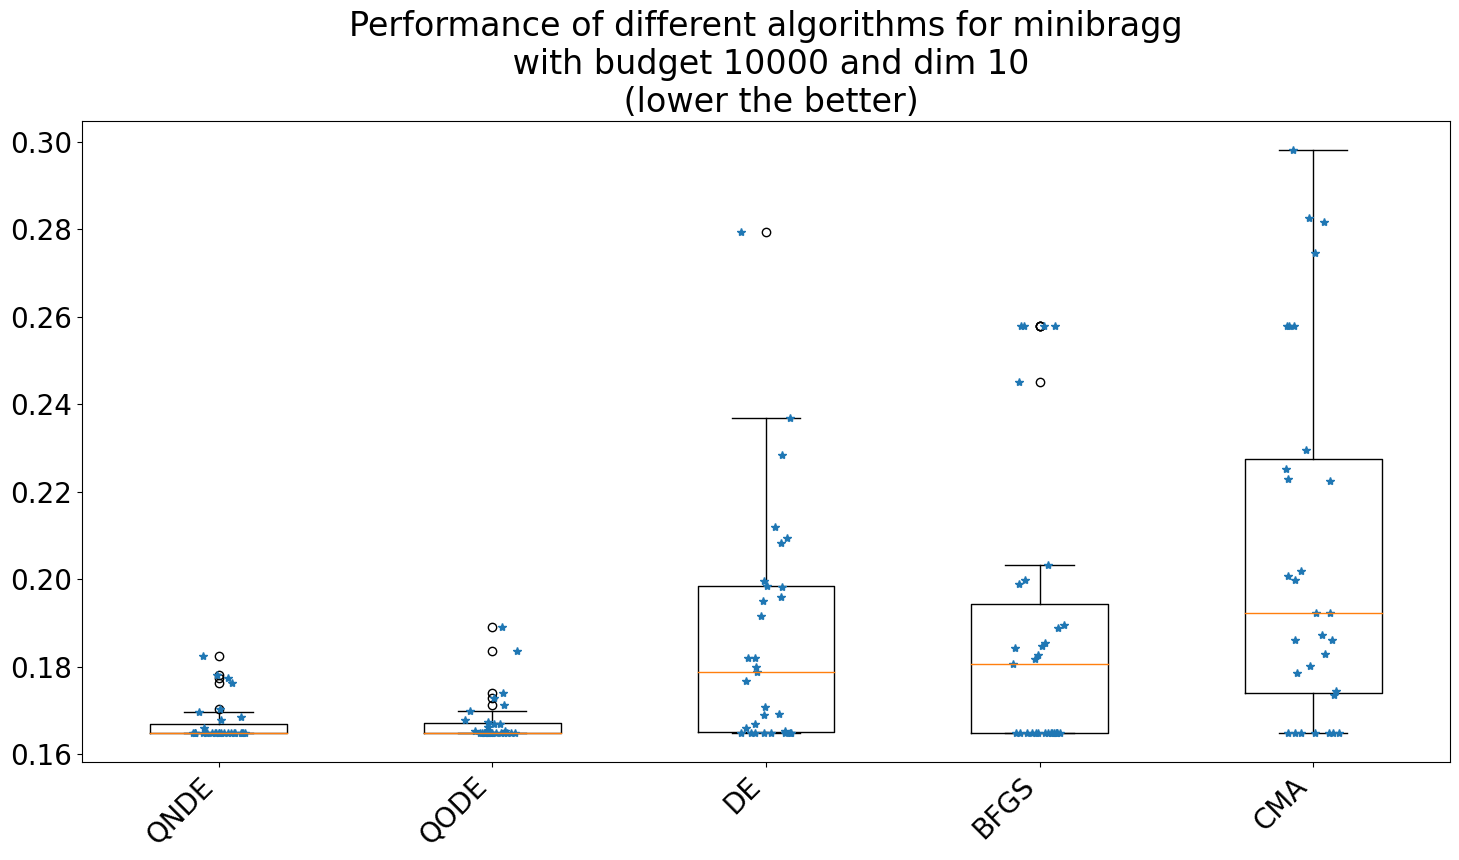

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

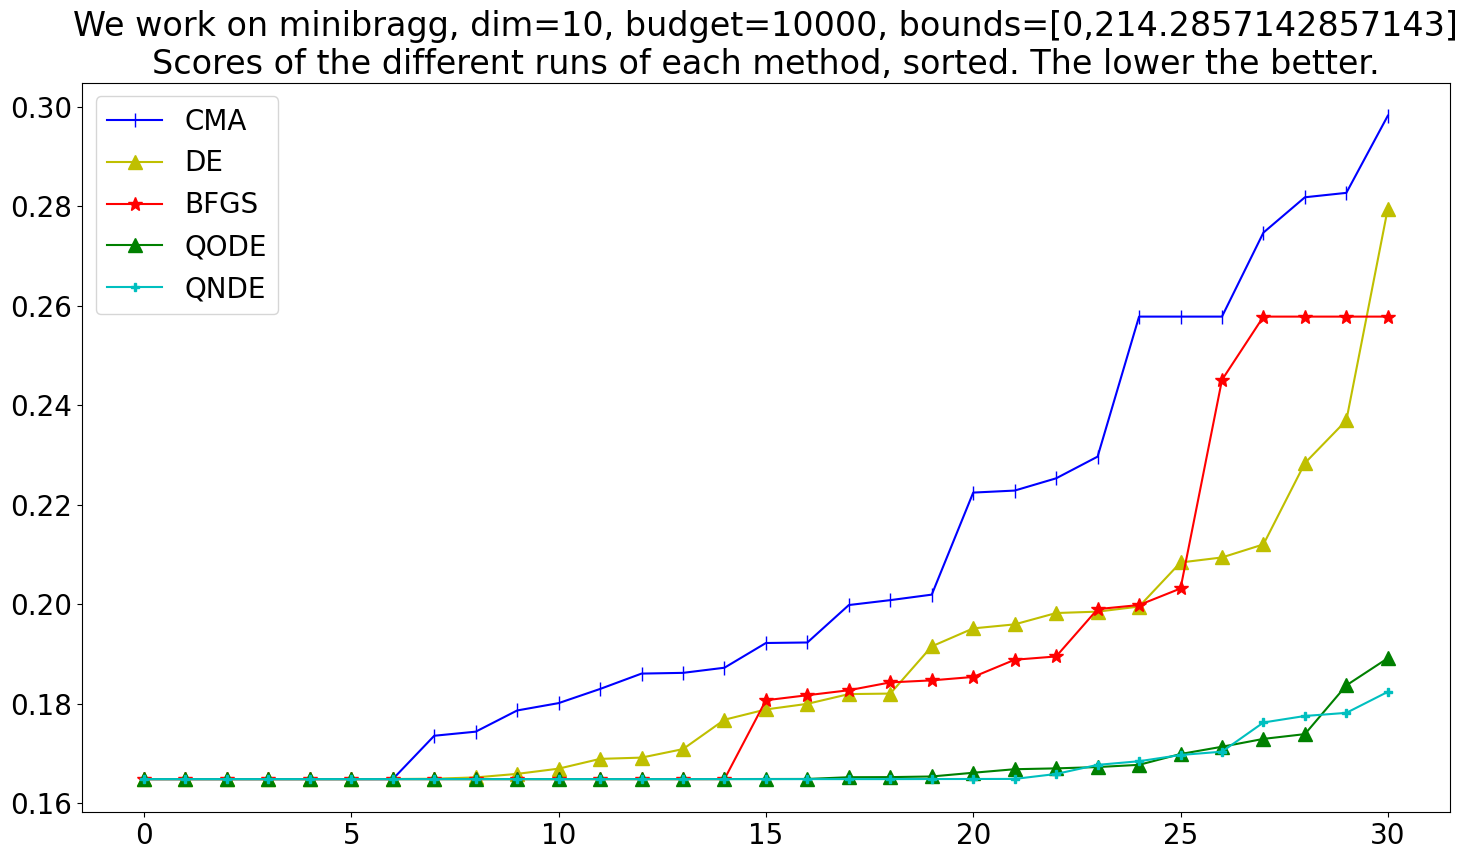

In [ ]:
if run_performance:
  import matplotlib.pyplot as plt
  plt.rcParams['font.size'] = "20" #str(int(plt.rcParams['font.size']) + 2)
  plt.rcParams['figure.figsize'] = [15, 9]
  plt.rcParams["figure.autolayout"] = True
  from google.colab import files

  angles = [c * 2 * 3.14159 / 10 for c in range(10)] + [0.]

  # Plotting the convergence curves, NOT aggregated.
  plt.clf()
  np.random.seed(7)
  for o in sorted(scores, key=lambda x: -np.sum(scores[x]) / len(scores[x])):
    print(o)
    print(o, xval, yval[o])
    yval_mean = [np.sum(yval[o][i]) / len(yval[o][i]) for i in range(len(yval[o]))]
    yval_std = [np.std(yval[o][i]) / np.sqrt(len(yval[o][i]) - 1) for i in range(len(yval[o]))]
    c = get_color(o)
    s = np.random.RandomState(doint(o)).choice([6, 10, 13])
    m = np.random.RandomState(doint(o)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])

    plt.semilogx(xval, yval_mean, label=o, c=c,
              marker=m, markersize=s)
    for k in range(len(yval[o][0])):
      yval_k = [yval[o][i][k] for i in range(len(yval[o]))]
      plt.semilogx(xval, yval_k, c=c, marker=m, markersize=s)
    #plt.annotate(o, (xval[-1], yval_mean[-1]), rotation=30)
    for i in range(len(xval)):
      #plt.plot([xval[i], xval[i]], [yval_mean[i] - yval_std[i], yval_mean[i] + yval_std[i]], c="k", marker="+")
      plt.plot([xval[i] * (1. + .1 * np.cos(theta)) for theta in angles], [yval_mean[i] + yval_std[i] * np.sin(theta) for theta in angles], c="grey", linestyle="dashed")
  plt.legend()
  plt.title(context_string + "\n Convergence curves")
  plt.tight_layout()
  plt.savefig("fcc" + obj_name + ".png")
  files.download("fcc" + obj_name + ".png")
  plt.savefig("fcc" + obj_name + ".svg")
  files.download("fcc" + obj_name + ".svg")
  plt.pause(0.05)

  # Plotting the convergence curves, aggregated.
  plt.clf()
  np.random.seed(7)
  for o in sorted(scores, key=lambda x: -np.sum(scores[x]) / len(scores[x])):
    print(o, xval, yval[o])
    yval_mean = [np.sum(yval[o][i]) / len(yval[o][i]) for i in range(len(yval[o]))]
    yval_std = [np.std(yval[o][i]) / np.sqrt(len(yval[o][i]) - 1) for i in range(len(yval[o]))]
    c = get_color(o)
    s = np.random.RandomState(doint(o)).choice([6, 10, 13])
    m = np.random.RandomState(doint(o)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])
    plt.semilogx(xval, yval_mean, label=o, c=c, marker=m, markersize=s)
    #plt.annotate(o, (xval[-1], yval_mean[-1]), rotation=30)
    for i in range(len(xval)):
      #plt.plot([xval[i], xval[i]], [yval_mean[i] - yval_std[i], yval_mean[i] + yval_std[i]], c="k", marker="+")
      plt.semilogx([xval[i] * (1. + .1 * np.cos(theta)) for theta in angles], [yval_mean[i] + yval_std[i] * np.sin(theta) for theta in angles], c="grey", linestyle="dashed")
  plt.legend()
  plt.title(context_string + "\n Convergence curves")
  plt.tight_layout()
  plt.savefig("cc" + obj_name + ".png")
  files.download("cc" + obj_name + ".png")
  plt.savefig("cc" + obj_name + ".svg")
  files.download("cc" + obj_name + ".svg")
  plt.pause(0.05)

  # Now pretty plotting with score on the x-axis and comp. time on the y-axis.
  plt.clf()
  maxi = max([np.sum(scores[o]) / len(scores[o]) for o in scores])
  mini = min([np.sum(scores[o]) / len(scores[o]) for o in scores])
  width = maxi - mini
  for i, o in enumerate(sorted(scores, key=lambda x: np.sum(computational_cost[x]) / len(scores[x]))):
    avg_score = np.sum(scores[o]) / len(scores[o])
    std_score = np.std(scores[o]) / np.sqrt(len(scores[o]))
    avg_time = np.sum(computational_cost[o]) / len(computational_cost[o])
    print(o, avg_score, "+-", std_score, "   in time ", avg_time)
    plt.annotate("     " + o, (avg_score, avg_time), rotation=0. + 70. * i / len(scores))
    plt.loglog([avg_score], [avg_time], '*')
    plt.loglog([avg_score-std_score, avg_score+std_score], [avg_time, avg_time], '-')
    plt.xlabel("Score")
    plt.ylabel("Comp. time")
  plt.title(context_string + "\n Loss vs computational cost")
  plt.tight_layout()
  plt.savefig("comptime" + obj_name + ".png")
  files.download("comptime" + obj_name + ".png")
  plt.savefig("comptime" + obj_name + ".svg")
  files.download("comptime" + obj_name + ".svg")
  plt.pause(0.05)

  # Boxplots for all algorithms.
  plt.clf()
  names = sorted(scores.keys(), key=lambda x: np.sum(scores[x]) / len(scores[x]))
  plt.boxplot([scores[o] for o in names])
  x = []
  y = []
  for u, k in enumerate(names):
    for i, s in enumerate(scores[k]):
      x += [u + 0.9 + np.random.rand() * .2]
      y += [sorted(scores[k])[i]]
  plt.plot(x, y, "*")
  import pylab
  ax = plt.gca()
  ax.set_xticklabels(ax.get_xticks(), rotation = 45, ha="right")
  pylab.xticks(range(1, len(names)+1), names)
  plt.title(f"Performance of different algorithms for {obj_name}\n with budget {budget} and dim {dim}\n (lower the better)")
  plt.tight_layout()
  plt.savefig("bp" + obj_name + ".png")
  files.download("bp" + obj_name + ".png")
  plt.savefig("bp" + obj_name + ".svg")
  files.download("bp" + obj_name + ".svg")
  plt.pause(0.05)

  # And consistency plots for all algorithms.
  plt.clf()
  names = sorted(scores.keys(), key=lambda x: -np.max(scores[x]))
  for k in names:
    c = get_color(k)
    s = np.random.RandomState(doint(k)).choice([6, 10, 13])
    m = np.random.RandomState(doint(k)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])
    plt.plot(range(len(scores[k])), sorted(scores[k], key=lambda x: x), label=k, c=c, marker=m, markersize=s)
  plt.legend()
  plt.title(f"{context_string}\nScores of the different runs of each method, sorted. The lower the better.")
  plt.tight_layout()
  plt.savefig("q" + obj_name + ".png")
  files.download("q" + obj_name + ".png")
  plt.savefig("q" + obj_name + ".svg")
  files.download("q" + obj_name + ".svg")